### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
    Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees, identify right error metrics.

### Data Pre-processing
#### Loading the required libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score 
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras import backend as K

In [3]:
tf.__version__

'2.3.0'

###### fix random seed for reproducibility

    Generally, Keras gets its source of randomness from the NumPy random number generator.
    
    In addition, TensorFlow has its own random number generator that must also be seeded by calling the set_random_seed() function immediately after the NumPy random number generator, as follows:

In [4]:
np.random.seed(123)

tf.random.set_seed(123)

#### Loading the data

In [5]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the number row and columns

In [6]:
data.shape

(61589, 23)

Display the columns

In [7]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

__See the top rows of the data__

In [8]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


__Shows a quick statistic summary of your data using describe__

In [9]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


__Display data type of each variable__

In [10]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 

    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [11]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [12]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

##### Delete sku attribute

In [13]:
np.size(np.unique(data.sku))

61589

In [14]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

In [15]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

### Preparing Data for Model building

In [17]:
data['went_on_backorder'] = data['went_on_backorder'].replace(to_replace=['No', 'Yes'], value=[0, 1])
data['went_on_backorder'].value_counts()

0    50296
1    11293
Name: went_on_backorder, dtype: int64

In [18]:
X, y = data.loc[:,data.columns!='went_on_backorder'], data.loc[:,'went_on_backorder']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(43112, 21)
(43112,)
(18477, 21)
(18477,)


In [22]:
X_train.dtypes

national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
dtype: object

In [23]:
cat_attr = list(X_train.select_dtypes(include=['category']).columns)
num_attr = list(X_train.select_dtypes(include=['number']).columns)

In [24]:
print(cat_attr)
print(num_attr)

['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']
['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']


#### Handling Numerical Columns

##### Imputation

In [25]:
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(X_train[num_attr])

X_train[num_attr] = imputer.transform(X_train[num_attr])
X_val[num_attr] = imputer.transform(X_val[num_attr])

C:\Users\chait\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\chait\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\chait\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [26]:
X_train.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
dtype: int64

In [27]:
X_val.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
dtype: int64

##### Standardize the data 


In [28]:
scaler = StandardScaler()
scaler.fit(X_train[num_attr])

StandardScaler()

In [29]:
scaler.mean_

array([280.39807942,   7.58475598,  31.7570746 , 180.32192893,
       333.50714418, 478.5932223 ,  48.70351642, 168.15587307,
       311.69379755, 459.47599276,  45.86509557,   1.33239005,
        -6.23209338,  -5.79506425,   1.13017257])

In [30]:
scaler.var_

array([1.65743285e+07, 3.96771734e+01, 8.41446996e+05, 3.84987183e+07,
       1.30909776e+08, 2.76547320e+08, 2.64594279e+06, 3.85766961e+07,
       1.10699939e+08, 2.26680875e+08, 1.26537112e+06, 7.44504380e+02,
       6.49465857e+02, 6.11292307e+02, 8.74380578e+02])

In [31]:
X_train_num = pd.DataFrame(scaler.transform(X_train[num_attr]), columns=num_attr)
X_val_num = pd.DataFrame(scaler.transform(X_val[num_attr]), columns=num_attr)

In [32]:
print(X_train_num.shape)
print(X_val_num.shape)

print(type(X_train_num))
print(type(X_val_num))

(43112, 15)
(18477, 15)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


#### Handling Categorical Columns
##### Imputation

In [33]:
imputer = SimpleImputer(strategy='most_frequent')

imputer = imputer.fit(X_train[cat_attr])

X_train[cat_attr] = imputer.transform(X_train[cat_attr])
X_val[cat_attr] = imputer.transform(X_val[cat_attr])

C:\Users\chait\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\chait\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\chait\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

##### One Hot Encoding

In [34]:
ohe = OneHotEncoder(handle_unknown='error')

In [35]:
ohe.fit(X_train[cat_attr])

columns_ohe = list(ohe.get_feature_names(cat_attr))
print(columns_ohe)

X_train_cat = ohe.transform(X_train[cat_attr])
X_val_cat = ohe.transform(X_val[cat_attr])

X_train_cat = pd.DataFrame(X_train_cat.todense(), columns=columns_ohe)
X_val_cat = pd.DataFrame(X_val_cat.todense(), columns=columns_ohe)

['potential_issue_No', 'potential_issue_Yes', 'deck_risk_No', 'deck_risk_Yes', 'oe_constraint_No', 'oe_constraint_Yes', 'ppap_risk_No', 'ppap_risk_Yes', 'stop_auto_buy_No', 'stop_auto_buy_Yes', 'rev_stop_No', 'rev_stop_Yes']


In [36]:
print(X_train_cat.shape)
print(X_val_cat.shape)

print(type(X_train_cat))
print(type(X_val_cat))

(43112, 12)
(18477, 12)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Merging of Numerical and Categorical Dataframes

In [37]:
X_train_proc = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_proc = pd.concat([X_val_num, X_val_cat], axis=1)

In [38]:
print(X_train_proc.shape)
print(y_train.shape)
print(X_val_proc.shape)
print(y_val.shape)

(43112, 27)
(43112,)
(18477, 27)
(18477,)


In [39]:
y_train

32557    0
35028    0
18       1
24527    0
54999    0
        ..
27190    0
55221    0
2605     1
35193    1
15355    0
Name: went_on_backorder, Length: 43112, dtype: int64

### Convert dataframe to numpy array to feed into Neural Networks

In [40]:
print(type(X_train_proc))
print(type(X_val_proc))

X_train_proc_arr = X_train_proc.values
X_val_proc_arr = X_val_proc.values

print(type(X_train_proc_arr))
print(type(X_val_proc_arr))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Perceptron Model

In [41]:
perceptron_model = Sequential()
perceptron_model.add(Dense(1, activation='sigmoid', input_shape=(27,)))

In [42]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall()])

In [43]:
perceptron_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [44]:
perceptron_model_history = perceptron_model.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
539/539 [==============================] - 1s 2ms/step - loss: 0.5000 - recall: 0.0395 - val_loss: 0.4730 - val_recall: 0.0025
Epoch 2/100
539/539 [==============================] - 0s 928us/step - loss: 0.4647 - recall: 0.0063 - val_loss: 0.4680 - val_recall: 0.0025
Epoch 3/100
539/539 [==============================] - 0s 913us/step - loss: 0.4617 - recall: 0.0065 - val_loss: 0.4656 - val_recall: 0.0037
Epoch 4/100
539/539 [==============================] - 0s 889us/step - loss: 0.4603 - recall: 0.0073 - val_loss: 0.4649 - val_recall: 0.0050
Epoch 5/100
539/539 [==============================] - 0s 878us/step - loss: 0.4595 - recall: 0.0082 - val_loss: 0.4647 - val_recall: 0.0056
Epoch 6/100
539/539 [==============================] - 0s 926us/step - loss: 0.4590 - recall: 0.0084 - val_loss: 0.4645 - val_recall: 0.0056
Epoch 7/100
539/539 [==============================] - 0s 889us/step - loss: 0.4586 - recall: 0.0090 - val_loss: 0.4645 - val_recall: 0.0056
Epoch 8/100
539

539/539 [==============================] - 1s 1ms/step - loss: 0.4539 - recall: 0.0108 - val_loss: 0.4625 - val_recall: 0.0094
Epoch 60/100
539/539 [==============================] - 1s 958us/step - loss: 0.4539 - recall: 0.0108 - val_loss: 0.4625 - val_recall: 0.0094
Epoch 61/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4538 - recall: 0.0106 - val_loss: 0.4626 - val_recall: 0.0088
Epoch 62/100
539/539 [==============================] - 1s 993us/step - loss: 0.4538 - recall: 0.0105 - val_loss: 0.4625 - val_recall: 0.0094
Epoch 63/100
539/539 [==============================] - 1s 944us/step - loss: 0.4537 - recall: 0.0106 - val_loss: 0.4625 - val_recall: 0.0094
Epoch 64/100
539/539 [==============================] - 1s 939us/step - loss: 0.4537 - recall: 0.0109 - val_loss: 0.4625 - val_recall: 0.0094
Epoch 65/100
539/539 [==============================] - 1s 974us/step - loss: 0.4536 - recall: 0.0109 - val_loss: 0.4624 - val_recall: 0.0094
Epoch 66/100
539/539 [=

##### Plot

In [46]:
print(perceptron_model_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


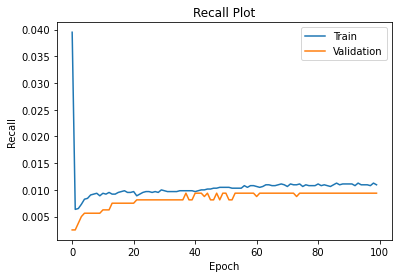

In [47]:
plt.plot(perceptron_model_history.history['recall'])
plt.plot(perceptron_model_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

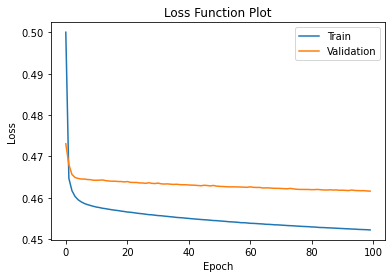

In [48]:
plt.plot(perceptron_model_history.history['loss'])
plt.plot(perceptron_model_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

##### Predictions

In [51]:
val_pred = perceptron_model.predict_classes(X_val_proc_arr)
train_pred = perceptron_model.predict_classes(X_train_proc_arr)

confusion_matrix_val = confusion_matrix(y_val, val_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[35162    45]
 [ 7819    86]]
[[15060    29]
 [ 3343    45]]


##### Train Test Accuracy, True Negative Rate and True Positive Rate

In [52]:
accuracy_score_train = accuracy_score(y_train, train_pred)
accuracy_score_val = accuracy_score(y_val, val_pred)

recall_score_train = recall_score(y_train, train_pred)
recall_score_val = recall_score(y_val, val_pred)

precision_score_train = precision_score(y_train, train_pred)
precision_score_val = precision_score(y_val, val_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8175913898682501
Train Recall:  0.010879190385831752
Train Precision:  0.6564885496183206
-----------------------
Val Accuracy:  0.8175028413703523
Val Recall:  0.013282172373081463
Val Precision:  0.6081081081081081


### Reference Links:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://keras.io/